Heat generation
==================
*01/2021: updated to pyGDM v1.1+*

In this example, light induced heat generation inside a planar plasmonic nano-structure will be demonstrated, reproducing results of Baffou *et al.* [1].

[1] Baffou, G. *Heat generation in plasmonic nanostructures: Influence of morphology*. **Applied Physics Letters** 94, 153109 (2009) (https://doi.org/10.1063/1.3116645)

Setup the simulation
------------------------

In [1]:
## --- load the modules
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import visu
from pyGDM2 import tools

import numpy as np
import matplotlib.pyplot as plt


## --- Setup structure (prism h=12nm, side=120nm in water on glass substrate)
step = 6.0
geometry = structures.prism(step, NSIDE=int(120/step), H=12/step, mesh='hex')
geometry = structures.center_struct(geometry)
material = materials.gold()
struct = structures.struct(step, geometry, material)


## --- Setup incident field
field_generator = fields.plane_wave  # planwave excitation
kwargs = dict(theta=0.0)             # X-polarized, top-incidence
wavelengths = np.linspace(500, 1000, 51)
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## --- Setup environment (water with glass substrate)
n1, n2 = 1.45, 1.33          # water on glass
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## --- Simulation initialization
sim = core.simulation(struct, efield, dyads)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 380/380 dipoles valid


Heat spectrum and -distribution inside structure
---------------------------------------------

After the main simulation routine (*core.scatter*), we calculate the spectrum of the total deposited heat as well as the heat-distribution inside the nano-structure at the plasmon resonance ($\lambda_{p} \approx 820\,$nm).

In [2]:
## --- main simulation
sim.scatter(verbose=False)


## --- heat spectrum
wl, heat_spectrum = tools.calculate_spectrum(sim, 0, linear.heat)

## --- heat distribution in struct at plasmon resonance
idx_struct = tools.get_closest_field_index(sim, dict(wavelength=820))
q = linear.heat(sim, idx_struct, return_value='structure')

## --- divide heat-distribution by cell volume --> nW/nm^3
q.T[3] /= (sim.struct.step**3/sim.struct.normalization)

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/linear.py:1320: UserWarning: `linear_py.heat` does not support tensorial permittivity yet.
  warnings.warn("`linear_py.heat` does not support tensorial permittivity yet.")


Plot
----------

Let's plot the spectrum and the heat distribution inside the structure:

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


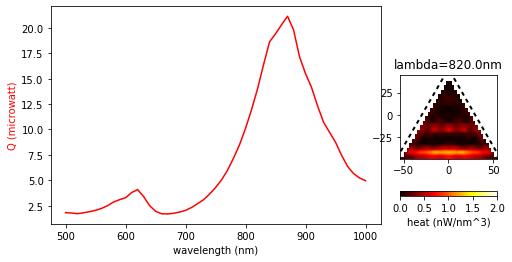

In [3]:
plt.figure( figsize=(8,4) )
plt.subplot2grid( (1,4), (0,0), colspan=3)

## --- spectrum
plt.plot(wl, heat_spectrum/1.0E3, color='r')
plt.xlabel("wavelength (nm)")
plt.ylabel("Q (microwatt)", color='r')


## --- heat distribution inside prism
plt.subplot(144, aspect='equal')
plt.title("lambda={}nm".format(wl[idx_struct]))
im = visu.scalarfield(q, cmap='hot', show=0, zorder=1)
plt.colorbar(im, label='heat (nW/nm^3)', orientation='horizontal', 
                                         ticks=[0,0.5,1,1.5,2])
im.set_clim([0, 2])

visu.structure_contour(sim, lw=2, color='k', dashes=[2,2],
                       input_mesh='hex1', zorder=0, borders=10, show=0)


plt.show()

This is in pretty good agreement with [1] (see above for reference).